# Problem 1

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier as KnnClf
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load and process the MNIST dataset
mnist = fetch_openml('mnist_784')
X, y = mnist.data, mnist.target
X, _ , y, _ = tts(X, y, test_size=0.9, random_state=42)
X = X / 255.0

## The Boostrap function for KNN

In [ ]:
def Bootstrap_Knn(X, y, k, iters):
  acc_result = []
  for _ in range(iters):
    ## sample
    id = np.random.randint(0, len(X), size=int(len(X)*0.8))
    X_train, X_valid, y_train, y_valid = tts(X, y, test_size=0.8)
    ## model training
    knn = KnnClf(n_neighbors=k)
    knn.fit(X_train, y_train)
    ## prediction
    y_pred = knn.predict(X_valid)
    ## accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    acc_result.append(accuracy)
    # print(k,"\t",_ )
  return  np.mean(acc_result)


## The most optimal $k$

Having prepared the data and defined the bootstrap function for the KNN classifier, let us determine the most optimal number of neighbors based on 1, 2, 11, 22, 44 and 88 iterations.

In [ ]:
k_values = list(range(1,11)) # k=1 has no sense

df = pd.DataFrame(columns=['k', 'iters', 'accuracy'])

for k in k_values:
  for i in [1,2,11, 22, 44, 88]:
    df = df._append({'k': k, 'iters': i, 'accuracy': Bootstrap_Knn(X, y, k, i)}, ignore_index=True)

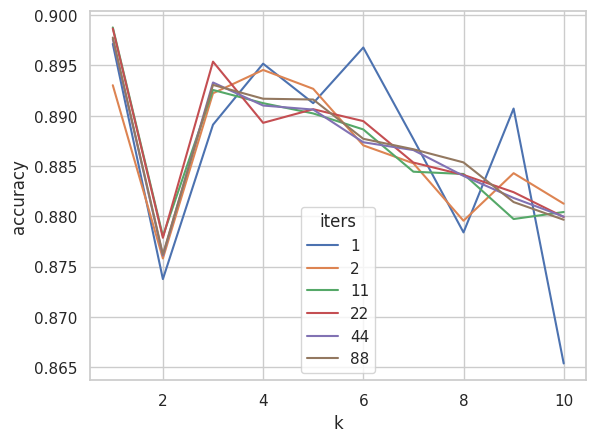

In [ ]:
df['iters']= df['iters'].astype(int).astype('category')
sns.set_theme(style="whitegrid")

sns.lineplot(x="k", y="accuracy", hue="iters", data=df)
plt.show()

We can see in the above plot that the most optimal number of nearest neigbors $k=3$. The choice of $k=1$ shows that we get even better accuracy, but such a model is the most complex and is most likely to overfit. We base the choice of $k=3$ on the bootstrap method, which consists in selecting the most optimal model based on the selection with replacement of the training and test sets in each of the $n$ iterations. Therefore, based on the 7000 data set, we should perform more than 2 iterations because within one or two iterations the bootstrap may select biased training sets, that is, sets that contain most of the outliers.

## The most optimal number of bootstrap iterations

Having previously determined the most optimal number of neighbors, let us now determine the most optimal number of iterations that we should use in bootstrap.

We will choose the optimal number of iterations based on the cumulative average of successive accuracy values, after performing 300 iterations.
We will then check after which the difference between two following cumulative averages will be less than 0.0001.

In [ ]:
df_acc = {'iters': list(range(1,301)), 'Accuracy': [Bootstrap_Knn(X,y,3,1) for _ in range(1,301)]}
df_acc = pd.DataFrame(df_acc)

In [ ]:
df_acc["cum_avg_acc"] = df_acc["Accuracy"].expanding().mean()
df_acc['iters']= df_acc['iters'].astype(int)
diff = [abs(df_acc['cum_avg_acc'][i] - df_acc['cum_avg_acc'][i-1]) for i in range(1,len(df_acc))]
df_acc['diff'] = [np.NaN] + diff


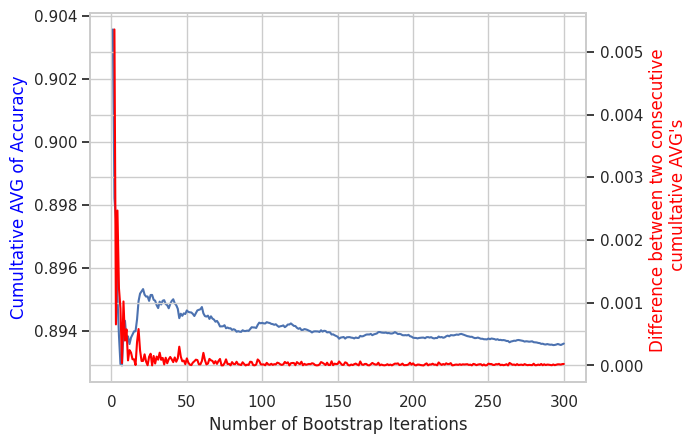

In [ ]:
fig, ax1 = plt.subplots()
sns.set_theme(style="whitegrid")

sns.lineplot(x="iters", y="cum_avg_acc", data=df_acc,  ax=ax1)
ax1.set_ylabel("Cumultative AVG of Accuracy", color="blue")
ax1.set_xlabel("Number of Bootstrap Iterations")
ax2 = ax1.twinx()
sns.lineplot(x="iters", y="diff", data=df_acc, color="red", ax=ax2)
ax2.set_ylabel("Difference between two consecutive \n cumultative AVG's", color="red")
plt.show()

In [ ]:
df_acc.loc[df_acc['diff'] < 0.0001]


,iters,Accuracy,cum_avg_acc,diff
6,7,0.892679,0.892908,0.000038
10,11,0.894643,0.893831,0.000081
13,14,0.895179,0.893890,0.000099
14,15,0.895357,0.893988,0.000098
15,16,0.894107,0.893996,0.000007
...,...,...,...,...
295,296,0.899107,0.893590,0.000019
296,297,0.888214,0.893571,0.000018
297,298,0.889286,0.893557,0.000014
298,299,0.900179,0.893579,0.000022


Based on the above graph and results, we can see that the optimal number of iterations is 14. Because the difference between two consecutive cumulative averages, starting from the number of iterations equal to 14, is less than 0.0001.